# ❓ Problem Statement

👋 Gesture Recognition

You are working as a data scientist at a leading electronics company, ‘SG Electrics' which manufactures state of the art Smart Televisions. As an addition to the smart features of the televisions, you are given the responsibility to develop a model that can recognise 5 different gestures listed below which will help the customers in navigating through the SMART TV without using the remote.

In this project, we are going to build a model that will be able to predict the 5 gestures correctly.

For the application of gesture recognition while watching a movie, the following gestures have been selected with their functionality as described:

Thumbs Up 👍: Increase the volume

Thumbs Down 👎: Lower the volume

Stop ✋: Pause the movie

Left Swipe : Fast Forward 10 seconds

Right Swipe: Fast Backward 10 seconds



In [ ]:
# Downgrading the module scipy to leverage the functionality of the imread and imresize
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
jax 0.3.14 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.


In [ ]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
# Please run this cell twice in order to import the libraries correctly. It errors out in the first try and works fine in the second one.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
# Mounting google drive to access the images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# Importing the files module to upload train and val in order to make them avaialable in CSV format
from google.colab import files

In [ ]:
train = files.upload()

Saving train.csv to train.csv


In [ ]:
val = files.upload()

Saving val.csv to val.csv


In [ ]:
# Reading the train and val files
train_doc = np.random.permutation(open('/content/train.csv').readlines())
val_doc = np.random.permutation(open('/content/val.csv').readlines())

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def get_batch_images(source_path, folder_list, batch_num, batch_size, t, validation, input_shape):
    
    batch_data = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2], input_shape[3])) 
    batch_labels = np.zeros((batch_size,5))
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = np.round(np.linspace(0,29,input_shape[0])).astype(int)

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (input_shape[1], input_shape[2]), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
       
    
    if validation:
        batch_data=batch_data
        batch_labels= batch_labels
        
    return batch_data,batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
def generator(source_path, folder_list, batch_size, input_shape, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # iterate over the number of batches
            # yield the batch_data and the batch_labels
            yield get_batch_images(source_path, folder_list, batch, batch_size, t,validation, input_shape)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield get_batch_images(source_path, folder_list, batch, batch_size, t,validation, input_shape)


In [ ]:
# Function to tweak the batch_size, number of epochs, input_shape and consequently steps_per_epoch and validation steps
def gen(batch_size, epochs, input_shape):
  train_path = '/content/drive/MyDrive/Project_data/train '
  val_path = '/content/drive/MyDrive/Project_data/val'
  num_train_sequences = len(train_doc)
  print('# training sequences =', num_train_sequences)
  num_val_sequences = len(val_doc)
  print('# validation sequences =', num_val_sequences)
  print('batch_size =', batch_size)
  num_epochs = epochs
  print('# epochs =', num_epochs)
  train_generator = generator(train_path, train_doc, batch_size, input_shape)
  val_generator = generator(val_path, val_doc, batch_size, input_shape, validation=True)
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  print('# steps per epoch ', steps_per_epoch)
  print('# validation steps ', validation_steps)
  print('Input Shape ', input_shape)
  return (train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs)

# Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Conv3D Models

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
# Defining the structure of model name to be stored
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Adding earlystopping callback
earlystop = EarlyStopping(monitor="val_categorical_accuracy", min_delta=0, patience=3, verbose=1)
# Adding model checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Adding reduce LR on plateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
# Defining a function to plot the training and validation accuracy
def plot(model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(model.history.history['loss'])   
    axes[0].plot(model.history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(model.history.history['categorical_accuracy'])   
    axes[1].plot(model.history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

**First we will go ahead and try to build various versions of a Conv3D model which then will be followed by a Conv2D + RNN, also known as LSTM models. We will compare all the models and select the best one in terms of loss, accuracy and number of parameters.** 

## Model 1: Conv3D 
A model considering all the frames in the image and image size being (120,120). BatchNormalization and Pooling layers have also been added.

In [ ]:
# Number of filters, each increasing index refers to the next layer
nb_filters = [8,16,32,64]
# Number of dense nuerons in fully connected layers, the last element refers to the number of classes
nb_dense = [256, 128, 5]

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))


model.add(Dense(nb_dense[1], activation='relu'))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining optimizer 
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 16)   6

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.9829 - categorical_accuracy: 0.2278  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.98289-0.22775-2.36919-0.19000.h5
11/11 [==============================] - 5859s 585s/step - loss: 1.9829 - categorical_accuracy: 0.2278 - val_loss: 2.3692 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.4074 - categorical_accuracy: 0.4032
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.40741-0.40316-4.73854-0.20312.h5
11/11 [==============================] - 233s 23s/step - loss: 1.4074 - categorical_accuracy: 0.4032 - val_loss: 4.7385 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.2019 - cate

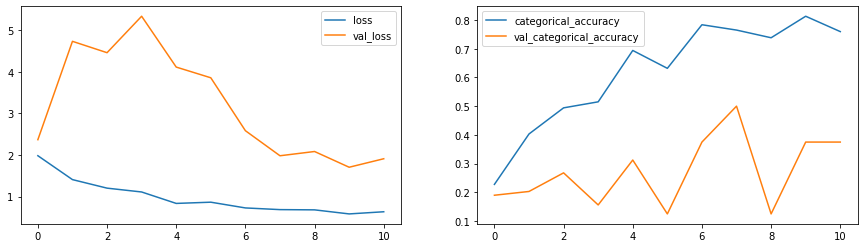

In [ ]:
# Plotting the results
plot(model)

**There are some signs of overfitting as there is a significance difference between categorical accuracy and validation accuracy.**

**Let's do some experiments. Let's try adding dropout layers to the current model to see how it affects our model performance.**

## Model 2: Conv3D 
A model considering all the frames in the image and image size being (120,120). BatchNormalization and Pooling layers, and droput layers have also been added.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining optimizer
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_4 (Batc  (None, 15, 60, 60, 16)  

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.9320 - categorical_accuracy: 0.2549Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.93200-0.25490-1.69432-0.15000.h5
11/11 [==============================] - 80s 8s/step - loss: 1.9320 - categorical_accuracy: 0.2549 - val_loss: 1.6943 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.4002 - categorical_accuracy: 0.4387
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.40025-0.43874-2.53645-0.29688.h5
11/11 [==============================] - 36s 4s/step - loss: 1.4002 - categorical_accuracy: 0.4387 - val_loss: 2.5365 - val_categorical_accuracy: 0.2969 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.3217 - categorical_

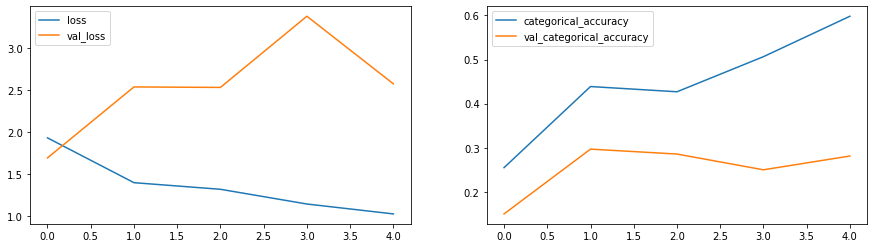

In [ ]:
# Plotting the results
plot(model)

Dropout with 0.25 doesn't seem to have dealt with the problem of overfitting.

## Model 3: Conv3D

A model considering only 20 out of the 30 frames in the image and image size being (120,120). BatchNormalization and Pooling layers, and droput layers with a value of 0.50 have also been added. Batch size has been reduced to 20 and number of epochs have been increased to 25.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(20,120,120,3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.50))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining the optimizer
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                                 
 batch_normalization_7 (Batc  (None, 10, 60, 60, 16)  

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 20, epochs = 25, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 20
# epochs = 25
# steps per epoch  34
# validation steps  5
Input Shape  (20, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.3020 - categorical_accuracy: 0.2519Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-2.30200-0.25189-2.28044-0.23000.h5
34/34 [==============================] - 56s 2s/step - loss: 2.3020 - categorical_accuracy: 0.2519 - val_loss: 2.2804 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5587 - categorical_accuracy: 0.2843
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.55874-0.28431-1.80107-0.25000.h5
34/34 [==============================] - 16s 478ms/step - loss: 1.5587 - categorical_accuracy: 0.2843 - val_loss: 1.8011 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.6092 - categoric

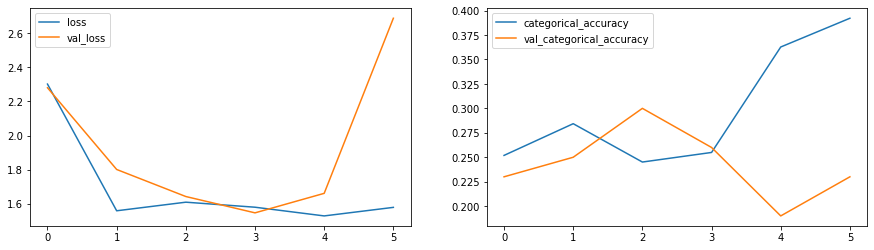

In [ ]:
# Plotting the results
plot(model)

**We observe a considerable amount of overfitting, hence on to the next architecture.**

## Model 4: Conv3D

In this model, we have used all the frames, (120,120) as image shape and reduced the filter size to (2,2,2). BatchNormalization and pooling layers have also been added. No dropouts have been used. Batch size has been increased to 32.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Define Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))


model.add(Dense(nb_dense[1], activation='relu'))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 16)    1040      
                                                                 
 batch_normalization_10 (Bat  (None, 15, 60, 60, 16)  

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 32, epochs = 25, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 32
# epochs = 25
# steps per epoch  21
# validation steps  4
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.8389 - categorical_accuracy: 0.3318Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.83892-0.33183-2.47287-0.24000.h5
21/21 [==============================] - 80s 4s/step - loss: 1.8389 - categorical_accuracy: 0.3318 - val_loss: 2.4729 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.9416 - categorical_accuracy: 0.6460
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-0.94158-0.64596-4.40869-0.18750.h5
21/21 [==============================] - 51s 3s/step - loss: 0.9416 - categorical_accuracy: 0.6460 - val_loss: 4.4087 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.7647 - categorical_

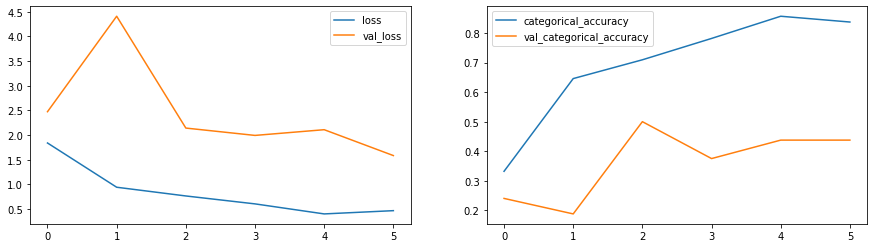

In [ ]:
# Plotting the results
plot(model)

**The accuracy has surely increased, but there are still signs of overfitting. We need to experiment further.**

## Model 5: Conv3D

In this model, we have used exactly the same architecture we used in Model 4, but added a dropout layer with a dropout value of 0.25 to address the issue of overfitting.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 16)    1040      
                                                                 
 batch_normalization_13 (Bat  (None, 15, 60, 60, 16)  

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 32, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 32
# epochs = 15
# steps per epoch  21
# validation steps  4
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.9117 - categorical_accuracy: 0.2911Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.91175-0.29110-1.44415-0.27000.h5
21/21 [==============================] - 80s 4s/step - loss: 1.9117 - categorical_accuracy: 0.2911 - val_loss: 1.4441 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.2438 - categorical_accuracy: 0.4865
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.24379-0.48654-1.79260-0.37500.h5
21/21 [==============================] - 50s 3s/step - loss: 1.2438 - categorical_accuracy: 0.4865 - val_loss: 1.7926 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.0117 - categorical_

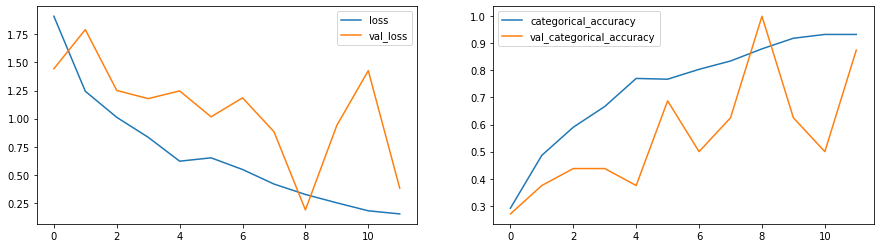

In [ ]:
# Plotting the model
plot(model)

**This model has given us the best results so far. Let's experiment some more to see if thigs can get better than this one.**

## Model 6: Conv3D

This model is another variation of Model 4. In this model, we have added dropout layers with a dropout value of 0.50. 

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.50))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 16)    1040      
                                                                 
 batch_normalization_16 (Bat  (None, 15, 60, 60, 16)  

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 32, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 32
# epochs = 15
# steps per epoch  21
# validation steps  4
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.8900 - categorical_accuracy: 0.2127Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-2.89000-0.21267-1.61323-0.22000.h5
21/21 [==============================] - 80s 4s/step - loss: 2.8900 - categorical_accuracy: 0.2127 - val_loss: 1.6132 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.4985 - categorical_accuracy: 0.3209
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.49852-0.32091-1.92195-0.31250.h5
21/21 [==============================] - 52s 3s/step - loss: 1.4985 - categorical_accuracy: 0.3209 - val_loss: 1.9220 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.4835 - categorical_

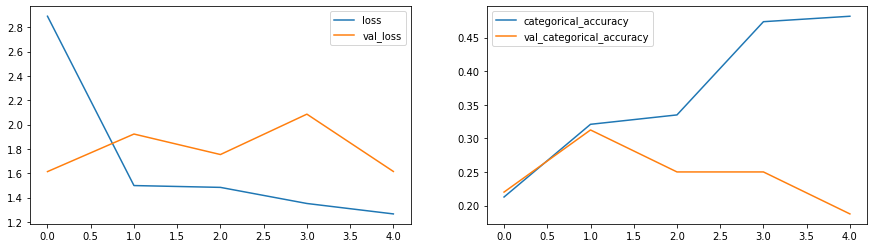

In [ ]:
# Plotting the model
plot(model)

**We haven't seen any appreciable improvements in the results. Let's experiment with some other aspects.**

## Model 7: Conv3D

In an attempt to reduce the number of parameters, we have reduced the number of frames to 16, decreased the batch size to 20 and reduced the size of the filter in the subsequent layers.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (16, 120, 120, 3)

model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,2,2), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining the optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 16)     1040      
                                                                 
 batch_normalization_19 (Bat  (None, 8, 60, 60, 16)   

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 20, epochs = 20, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 20
# epochs = 20
# steps per epoch  34
# validation steps  5
Input Shape  (16, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5222 - categorical_accuracy: 0.4253Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.52216-0.42534-4.28741-0.22000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.5222 - categorical_accuracy: 0.4253 - val_loss: 4.2874 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4060 - categorical_accuracy: 0.4804
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.40601-0.48039-4.02499-0.18000.h5
34/34 [==============================] - 13s 408ms/step - loss: 1.4060 - categorical_accuracy: 0.4804 - val_loss: 4.0250 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5696 - categoric

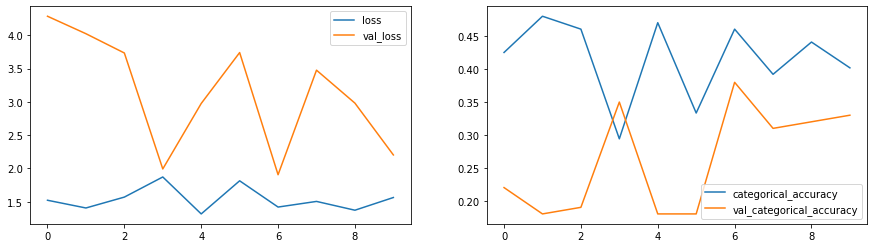

In [ ]:
# Plotting the results
plot(model)

**The performance given by this model isn't up to what we expected. Moving on to the next architecture.**

## Model 8: Conv3D

This model is built by tweeking the dropout value to 0.5 and increasing the filter size back to (3,3,3) in the input layer.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (16, 120, 120, 3)

# Model Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 batch_normalization_23 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 batch_normalization_24 (Bat  (None, 8, 60, 60, 16)   

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (16, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.3887 - categorical_accuracy: 0.2579Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-2.38867-0.25792-4.62148-0.22000.h5
11/11 [==============================] - 44s 4s/step - loss: 2.3887 - categorical_accuracy: 0.2579 - val_loss: 4.6215 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.8730 - categorical_accuracy: 0.3320
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.87301-0.33202-4.57880-0.37500.h5
11/11 [==============================] - 20s 2s/step - loss: 1.8730 - categorical_accuracy: 0.3320 - val_loss: 4.5788 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.8257 - categorical_

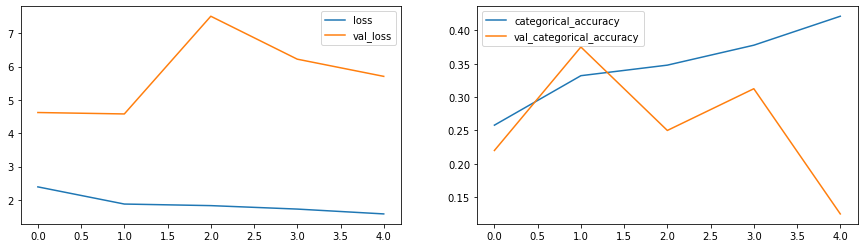

In [ ]:
# Plotting the model
plot(model)

**We have been successful in reducing the number of parameters but it has cost us dearly in terms of accuracy.**

## Model 9: Conv3D

This model is another variation of Model 7, with an added dropout layer with a dropout value of 0.25 and set filter size to (3,3,3).

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (16, 120, 120, 3)

# Defining Architecture
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 batch_normalization_28 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 batch_normalization_29 (Bat  (None, 8, 60, 60, 16)   

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (16, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.7422 - categorical_accuracy: 0.3665Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.74216-0.36652-3.58260-0.29000.h5
11/11 [==============================] - 44s 4s/step - loss: 1.7422 - categorical_accuracy: 0.3665 - val_loss: 3.5826 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.1145 - categorical_accuracy: 0.5968
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.11452-0.59684-4.32501-0.18750.h5
11/11 [==============================] - 19s 2s/step - loss: 1.1145 - categorical_accuracy: 0.5968 - val_loss: 4.3250 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.1817 - categorical_

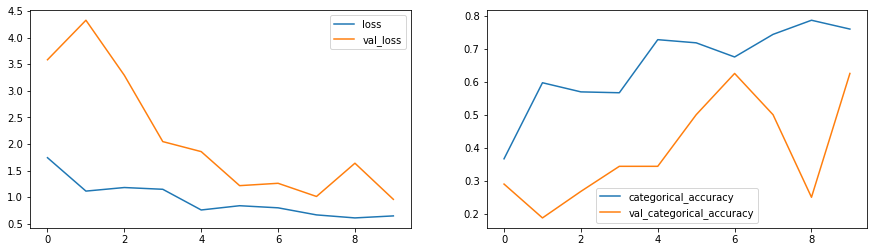

In [ ]:
plot(model)

**We have seen some improvement in terms of accuracy but the problem of overfitting has still not been solved.**

**We have built a total of 9 Conv3D models by tweeking the parameters like input_shape, kernel_size, dropout layers with different dropout values, batch_size and the number of epochs. Throughout this experimentation journey, we have been able to build several models with acceptable performance out of which we are going to select one.**

# CNN + RNN or LSTM Models

## Model 10: LSTM 

In this model we have used 18 out of the 30 frames along with BatchNormalization, MaxPooling and Dropout layers with a dropout value of 0.25, batch_size of 20 and 20 as the number of epochs.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, LSTM

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (18, 120, 120, 3)

# Model Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_116 (TimeD  (None, 18, 60, 60, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 20, epochs = 20, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 20
# epochs = 20
# steps per epoch  34
# validation steps  5
Input Shape  (18, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3537 - categorical_accuracy: 0.4238Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.35370-0.42383-2.15714-0.23000.h5
34/34 [==============================] - 52s 2s/step - loss: 1.3537 - categorical_accuracy: 0.4238 - val_loss: 2.1571 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3692 - categorical_accuracy: 0.4804
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.36917-0.48039-1.74371-0.23000.h5
34/34 [==============================] - 15s 454ms/step - loss: 1.3692 - categorical_accuracy: 0.4804 - val_loss: 1.7437 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3756 - categoric

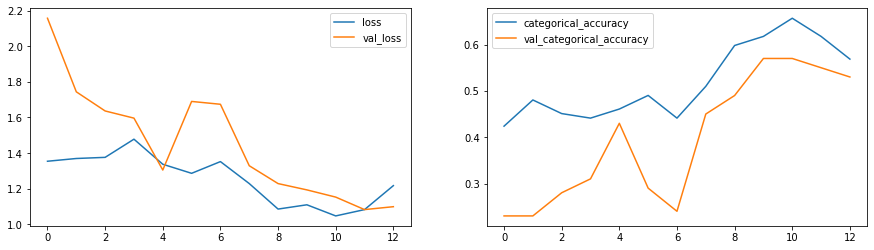

In [ ]:
# Plotting the results
plot(model)

**As we can see, there's hardly any overfitting with this one, but we still have a lot of room for improvement in terms of accuracy.**

## Model 11: LSTM 

In this model, we have added another hidden layer to see if it helps in increasing accuracy.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (18, 120, 120, 3)

# Model Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_128 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_129 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_130 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_131 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_132 (TimeD  (None, 18, 60, 60, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 20, epochs = 20, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 20
# epochs = 20
# steps per epoch  34
# validation steps  5
Input Shape  (18, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3041 - categorical_accuracy: 0.4404Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.30413-0.44042-2.15746-0.24000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.3041 - categorical_accuracy: 0.4404 - val_loss: 2.1575 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4024 - categorical_accuracy: 0.4020
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.40235-0.40196-1.80502-0.20000.h5
34/34 [==============================] - 15s 454ms/step - loss: 1.4024 - categorical_accuracy: 0.4020 - val_loss: 1.8050 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5203 - categoric

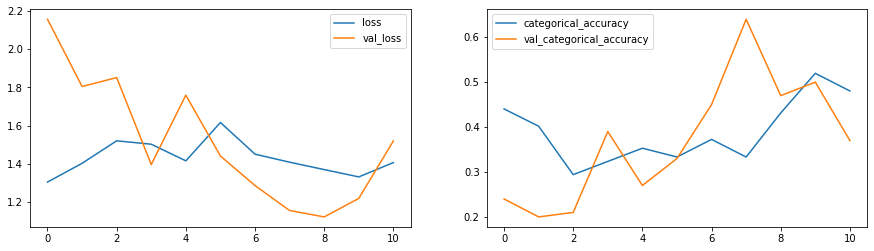

In [ ]:
# Plotting the results
plot(model)

**Addition of another hidden layer did not help us with any increase in the accuracy.**

## Model 12: LSTM

In this model, we have altered the dropout layers by increasing the dropout value to 0.5. Rest of the architecture is same as the one used in Model 10.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape = (18, 120, 120, 3)

# Define Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.50))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Define Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_166 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_167 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_168 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_169 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_170 (TimeD  (None, 18, 60, 60, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 20, epochs = 20, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 20
# epochs = 20
# steps per epoch  34
# validation steps  5
Input Shape  (18, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4305 - categorical_accuracy: 0.4027Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.43053-0.40271-2.22842-0.23000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.4305 - categorical_accuracy: 0.4027 - val_loss: 2.2284 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4667 - categorical_accuracy: 0.4020
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.46671-0.40196-2.08336-0.20000.h5
34/34 [==============================] - 15s 462ms/step - loss: 1.4667 - categorical_accuracy: 0.4020 - val_loss: 2.0834 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5277 - categoric

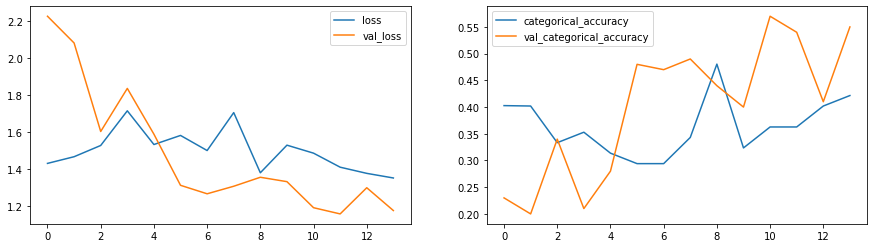

In [ ]:
# Plotting the model
plot(model)

**The overall performance of this model is not up to the mark. Neither the accuracy achieved is good nor the problem of overfitting has been addressed.**

## Model 13: LSTM

In this model, we have used all the 30 frames along with an image size of (120,120). BatchNormaliztion, Max Pooling and Dropout layers with a dropout value of 0.50 have also been used. Batch size has been increased to 64 and number of epochs is set to 15.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,120,120,3)

# Define Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.50))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(nb_dense[2], activation='softmax'))


In [ ]:
# Defining Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 30, 60, 60, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (30, 120, 120, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.5730 - categorical_accuracy: 0.3122Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.57298-0.31222-1.69025-0.30000.h5
11/11 [==============================] - 84s 8s/step - loss: 1.5730 - categorical_accuracy: 0.3122 - val_loss: 1.6903 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.3303 - categorical_accuracy: 0.4506
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.33029-0.45059-1.79689-0.23438.h5
11/11 [==============================] - 37s 4s/step - loss: 1.3303 - categorical_accuracy: 0.4506 - val_loss: 1.7969 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.2831 - categorical_

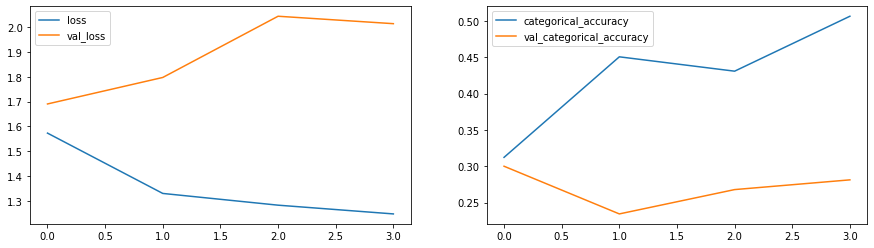

In [ ]:
# Plotting the model
plot(model)                                                                                                                                                                            

**This architecture has also got the problem of overfitting.**

## Model 14: LSTM

In this model, we have tried to experiment with the size of image being fed to the neural network. All the 30 frames are being considered here and the image size has been reduced to (100, 100). BatchNormalization, MaxPooling and Dropout layers with a dropout value of 0.50 have also been used. Batch size is 64 and the number of epochs is set to 15.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(30,100,100,3)

# Define Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.50))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 50, 50, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (30, 100, 100, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.5480 - categorical_accuracy: 0.3258Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.54797-0.32579-1.73511-0.24000.h5
11/11 [==============================] - 87s 8s/step - loss: 1.5480 - categorical_accuracy: 0.3258 - val_loss: 1.7351 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.2947 - categorical_accuracy: 0.4545
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.29469-0.45455-2.04617-0.25000.h5
11/11 [==============================] - 39s 4s/step - loss: 1.2947 - categorical_accuracy: 0.4545 - val_loss: 2.0462 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.2517 - categorical_

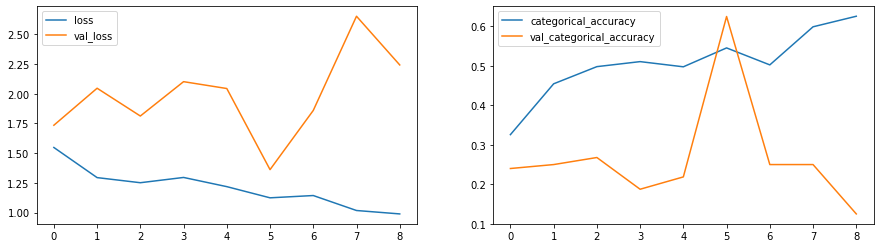

In [ ]:
# Plotting the model
plot(model)

**The accuracy has certainly increased but the model is still overfitting on the validation set.**

## Model 15: LSTM

In this model, we have reduced the number of frames to 16 keeping the size of image as (100, 100). Rest all parameters are same as Model 14.

In [ ]:
# Input Shape of the image in the format: (number of frames, image height, image width, number of channels)
input_shape=(16,100,100,3)

# Define Architecture
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.50))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
# Defining Optimizer
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 16, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 16, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 16, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 16, 50, 50, 32) 

In [ ]:
# Setting batch_size and num_epochs
(train_generator, val_generator, steps_per_epoch, validation_steps, num_epochs) = gen(batch_size = 64, epochs = 15, input_shape = input_shape)

# training sequences = 663
# validation sequences = 100
batch_size = 64
# epochs = 15
# steps per epoch  11
# validation steps  2
Input Shape  (16, 100, 100, 3)


In [ ]:
# Fitting the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train  ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.5448 - categorical_accuracy: 0.3213Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-08-1113_02_18.794768/model-00001-1.54477-0.32127-1.76400-0.26000.h5
11/11 [==============================] - 48s 4s/step - loss: 1.5448 - categorical_accuracy: 0.3213 - val_loss: 1.7640 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.3496 - categorical_accuracy: 0.4190
Epoch 2: saving model to model_init_2022-08-1113_02_18.794768/model-00002-1.34959-0.41897-2.26624-0.18750.h5
11/11 [==============================] - 20s 2s/step - loss: 1.3496 - categorical_accuracy: 0.4190 - val_loss: 2.2662 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.2642 - categorical_

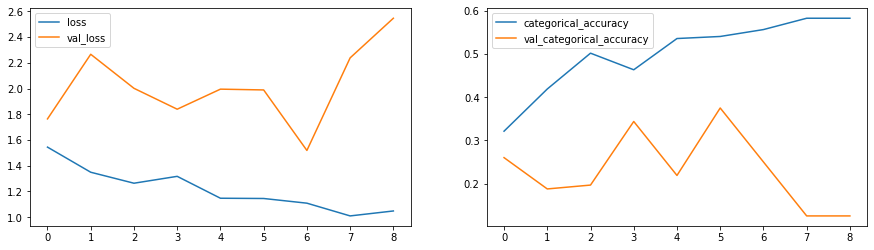

In [ ]:
# Plotting the results
plot(model)

**The model seems to have achieved a better accuracy but the problem of overfitting is persistent.**

# Best Model

**After building a total of 15 models, the best model which we have selected keeping in mind the number of parameters, the accuracy and the amount of overfitting, is Model 5.**

The specifications of the best model is:

1. Training accuracy: 93%
2. Validation accuracy: 87.5%
3. Number of Frames: 30
4. Image Size: 120, 120
5. Filter Size: 2,2,2
6. Batch Size: 32
7. Number of Epochs: 15
8. Total Parameters: 840k (approximately) 

